In [12]:
import pandas as pd
import pandas_gbq
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import re

In [43]:
query = """with initial_dataset as (
  select
    event_name,
    optional_label,
    event_timestamp,
    event_date,
    user_id,
    user_pseudo_id,
    ga_session_id,
    user_history_event_number,
    ga_session_number,
    session_event_number,
    platform,
    device_language,
    country
  from
    analytics_151430920.firebase_facts_events as eve
  where
    eve.event_timestamp >= '2020-11-01'
  and
    eve.event_name in ('sv__OnBoardingTutorialView','sv__WelcomeCarouselDialog','sv__NewPremiumAct','TryToBuyNewPAct','TryToBuyNewPF','ClickOnWholeView','StartListening','sv__StoryDetails','StartNStory','StartBekids','FabClickedPremium','PremiumBarClickedSD','PremiumBarClickedMain','AAPageA','ProPageA','GoldPageA','AAPageF','ProPageF','GoldPageF','EnterFcMore','sv__GlossaryF','LibraryClicked','sv__Libraries','PlayPrevParagraphFromButton','PlayNextParagraphFromButton','in_app_purchase','PurchaseNormal')
),   

premium_promo_shown as (
  select distinct
    user_pseudo_id,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_premium_promo_shown_timestamp
  from
    initial_dataset
  where
    event_name = 'sv__WelcomeCarouselDialog'
),

purchases as (
  select distinct
    'in_app_purchase' as event_name,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_timestamp,
    first_value(event_date) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_date,
    first_value(optional_label) over (partition by user_pseudo_id order by event_timestamp) as optional_label,
    last_value(user_id) over (partition by user_pseudo_id order by event_timestamp) as user_id,
    user_pseudo_id,
    first_value(ga_session_id) over (partition by user_pseudo_id order by event_timestamp) as ga_session_id,
    first_value(user_history_event_number) over (partition by user_pseudo_id order by event_timestamp) as user_history_event_number,
    first_value(session_event_number) over (partition by user_pseudo_id order by event_timestamp) as session_event_number,
    first_value(ga_session_number) over (partition by user_pseudo_id order by event_timestamp) as ga_session_number,
    first_value(platform) over (partition by user_pseudo_id order by event_timestamp) as platform,
    first_value(device_language) over (partition by user_pseudo_id order by event_timestamp) as device_language,
    first_value(country) over (partition by user_pseudo_id order by event_timestamp) as country
  from
    initial_dataset
  where
    event_name in ('in_app_purchase','PurchaseNormal')
), 

all_purchases as (
  select
    pu.event_name,
        case 
          when ps.first_premium_promo_shown_timestamp is null then 'iOS' 
          when pu.first_purchase_timestamp > timestamp_add(ps.first_premium_promo_shown_timestamp, interval 30 minute) then 'Android - no discount' else 'Android - discount' end as purchase_with_discount,
    ps.user_pseudo_id as premium_shown_user_pseudo_id,

    pu.first_purchase_timestamp,
    pu.first_purchase_date,
    ps.first_premium_promo_shown_timestamp,
    pu.optional_label,
    pu.user_id,
    pu.user_pseudo_id,
    pu.ga_session_id,
    pu.ga_session_number,
    pu.user_history_event_number,
    pu.session_event_number,
    pu.platform,
    pu.device_language,
    pu.country

  from
    purchases as pu
  left join
    premium_promo_shown as ps on ps.user_pseudo_id = pu.user_pseudo_id
)

select
  first_purchase_date,
  purchase_with_discount,
  case when ga_session_number > 1 then '2+' else '1' end as nth_session,
  count(*)
from
  all_purchases
group by 1,2,3
order by 1 desc, 2 desc, 3 desc;"""

df2 = pandas_gbq.read_gbq(query, project_id= 'beelinguapp') 

In [3]:
all_events_query = """with initial_dataset as (
  select
    event_name,
    optional_label,
    event_timestamp,
    event_date,
    user_id,
    user_pseudo_id,
    ga_session_id,
    user_history_event_number,
    session_event_number,
    platform,
    device_language,
    country
  from
    analytics_151430920.firebase_facts_events as eve
  where
    eve.event_timestamp >= '2020-11-01'
  and
    eve.event_name in ('sv__OnBoardingTutorialVie','sv__OnBoardingTutorialVi','sv__WelcomeCarouselDialog','sv__NewPremiumAct','TryToBuyNewPAct','TryToBuyNewPF','ClickOnWholeView','StartListening','sv__StoryDetails','StartNStory','StartBekids','FabClickedPremium','PremiumBarClickedSD','PremiumBarClickedMain','AAPageA','ProPageA','GoldPageA','AAPageF','ProPageF','GoldPageF','EnterFcMore','sv__GlossaryF','LibraryClicked','sv__Libraries','PlayPrevParagraphFromButton','PlayNextParagraphFromButton','in_app_purchase','PurchaseNormal')
),

onboarding as (
  select distinct
    'onboarding' as event_name,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as onboarding_timestamp,
    first_value(event_date) over (partition by user_pseudo_id order by event_timestamp) as onboarding_date,
    first_value(optional_label) over (partition by user_pseudo_id order by event_timestamp) as optional_label,
    last_value(user_id) over (partition by user_pseudo_id order by event_timestamp) as user_id,
    user_pseudo_id,
    first_value(ga_session_id) over (partition by user_pseudo_id order by event_timestamp) as ga_session_id,
    first_value(user_history_event_number) over (partition by user_pseudo_id order by event_timestamp) as user_history_event_number,
    first_value(session_event_number) over (partition by user_pseudo_id order by event_timestamp) as session_event_number,
    first_value(platform) over (partition by user_pseudo_id order by event_timestamp) as platform,
    first_value(device_language) over (partition by user_pseudo_id order by event_timestamp) as device_language,
    first_value(country) over (partition by user_pseudo_id order by event_timestamp) as country
  from
    initial_dataset
  where
    event_name in ('sv__OnBoardingTutorialVi','sv__OnBoardingTutorialVie')
),

purchases as (
  select distinct
    'in_app_purchase' as event_name,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_timestamp,
    first_value(event_date) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_date,
    first_value(optional_label) over (partition by user_pseudo_id order by event_timestamp) as optional_label,
    last_value(user_id) over (partition by user_pseudo_id order by event_timestamp) as user_id,
    user_pseudo_id,
    first_value(ga_session_id) over (partition by user_pseudo_id order by event_timestamp) as ga_session_id,
    first_value(user_history_event_number) over (partition by user_pseudo_id order by event_timestamp) as user_history_event_number,
    first_value(session_event_number) over (partition by user_pseudo_id order by event_timestamp) as session_event_number,
    first_value(platform) over (partition by user_pseudo_id order by event_timestamp) as platform,
    first_value(device_language) over (partition by user_pseudo_id order by event_timestamp) as device_language,
    first_value(country) over (partition by user_pseudo_id order by event_timestamp) as country
  from
    initial_dataset
  where
    event_name in ('in_app_purchase','PurchaseNormal')
),

relevant_events as (
  select
    ini.event_name,
    ini.event_timestamp,
    ini.event_date,
    ini.optional_label,
    ini.user_id,
    ini.user_pseudo_id,
    ini.ga_session_id,
    ini.user_history_event_number,
    ini.session_event_number,
    ini.platform,
    ini.device_language,
    ini.country
  from
    initial_dataset as ini
  left join
    purchases as pur on pur.user_pseudo_id = ini.user_pseudo_id
  left join
    onboarding as onb on onb.user_pseudo_id = ini.user_pseudo_id
  where
    ini.event_name not in ('in_app_purchase','PurchaseNormal','sv__OnBoardingTutorialVi','sv__OnBoardingTutorialVie')
  and
    ini.event_timestamp between onb.onboarding_timestamp and timestamp_add(onb.onboarding_timestamp, interval 7 day)
  union all
  select
    rep.event_name,
    rep.first_purchase_timestamp as event_timestamp,
    rep.first_purchase_date as event_date,
    rep.optional_label,
    rep.user_id,
    rep.user_pseudo_id,
    rep.ga_session_id,
    rep.user_history_event_number,
    rep.session_event_number,
    rep.platform,
    rep.device_language,
    rep.country
  from
    purchases as rep
)

select
  user_pseudo_id,
  event_name,
  count(event_timestamp) as occurrences_count,
  min(event_timestamp) as first_event_timestamp,
  max(event_timestamp) as last_event_timestamp
from
  relevant_events
group by 1,2;
"""
df = pandas_gbq.read_gbq(all_events_query, project_id= 'beelinguapp')

,user_pseudo_id,event_name,occurrences_count,first_event_timestamp,last_event_timestamp
0,BE5C97B244EA446CBD8771C34368D3C1,in_app_purchase,1,2020-11-03 16:11:10.476000+00:00,2020-11-03 16:11:10.476000+00:00
1,459828e7f86ce0f682b0a69dd2c0dc36,in_app_purchase,1,2020-11-18 16:55:09.613000+00:00,2020-11-18 16:55:09.613000+00:00
2,d3340c736688d7119d1b5a0d2a6b535e,in_app_purchase,1,2020-11-17 13:40:31.326000+00:00,2020-11-17 13:40:31.326000+00:00
3,e3a752ea54b79385e88bed8562d3aa35,in_app_purchase,1,2020-12-05 14:22:44.348000+00:00,2020-12-05 14:22:44.348000+00:00
4,4a32180131bab101d10186947720d714,in_app_purchase,1,2020-11-22 23:21:04.895000+00:00,2020-11-22 23:21:04.895000+00:00


**checking the value counts for event_name and info**

In [6]:
df.event_name.value_counts()

sv__Libraries                106023
ClickOnWholeView              69156
sv__WelcomeCarouselDialog     62812
StartListening                60758
sv__StoryDetails              55499
StartNStory                   54142
LibraryClicked                23947
sv__NewPremiumAct             16775
PremiumBarClickedMain          9315
StartBekids                    5974
sv__GlossaryF                  5461
PremiumBarClickedSD            4245
FabClickedPremium              2448
EnterFcMore                    2273
TryToBuyNewPAct                2010
in_app_purchase                1177
TryToBuyNewPF                   700
Name: event_name, dtype: int64

In [57]:
df.event_name.nunique()

17

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482715 entries, 0 to 482714
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   user_pseudo_id         482715 non-null  object             
 1   event_name             482715 non-null  object             
 2   occurrences_count      482715 non-null  int64              
 3   first_event_timestamp  482715 non-null  datetime64[ns, UTC]
 4   last_event_timestamp   482715 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(1), object(2)
memory usage: 14.7+ MB


**Purchases Based on Platforms**

In [10]:
df[df.event_name=='in_app_purchase']['user_pseudo_id'].nunique() == len(df[df.event_name=='in_app_purchase']['user_pseudo_id'])
# looking for whether there is more than 1 in_app_purchase per user

True

In [72]:
df['platform'] = df['user_pseudo_id'].apply(lambda x: 'Android' if re.findall('[a-z]',x) else 'IOS')
# creating platform column based on user_pseudo_id

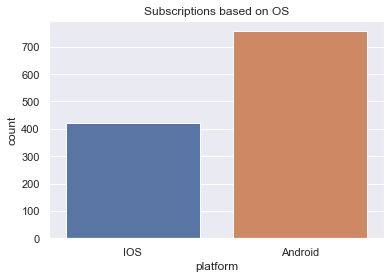

In [73]:
sns.set_theme(style="darkgrid")
sns.countplot(x='platform',data=df[df.event_name=='in_app_purchase'])
plt.title('Subscriptions based on OS')
plt.show()
# indicate in_app_purchases based on different OS

**Heat Map**

In [74]:
df_log = df.pivot_table(index=["user_pseudo_id"],columns=["event_name"],fill_value=0)
# getting the events_occurences aggregated in user_pseudo_level

In [75]:
df_log.columns = df_log.columns.droplevel()
# flattening the columns

In [76]:
df_log.reset_index(inplace=True)
# converting user_pseudo_id as a column

In [77]:
df_log['platform'] = df_log['user_pseudo_id'].apply(lambda x: 'Android' if re.findall('[a-z]',x) else 'IOS')
#adding platforms to df_log

In [85]:
df_log['in_app_purchase'].value_counts()
#there are 2 event occurences in_app_purchases

0    120277
1      1171
2         6
Name: in_app_purchase, dtype: int64

In [86]:
df[(df.event_name=='in_app_purchase') & (df.occurrences_count > 1)]['user_pseudo_id']
#users who purchased more than 1

1722    9bdf2b9dc1e36c56dc20d1b8e05d2e92
2087    f0f56bd5124953d82601d336f4a70a02
2475    f768bb55076b14d51a52b709ff09a839
3254    e9aaf33848e3975412faa35cb045402f
3629    bfcd61286b149a8b98ab867c2a13df33
4921    266edf372500183f0e8bd7c2a5e89c04
Name: user_pseudo_id, dtype: object

In [89]:
df_log['in_app_purchase'] = np.where(df_log['in_app_purchase']>0,1,0)
#converting in_app_purchase as binary

In [90]:
df_log['in_app_purchase'].value_counts()
#checking the value counts again

0    120277
1      1177
Name: in_app_purchase, dtype: int64

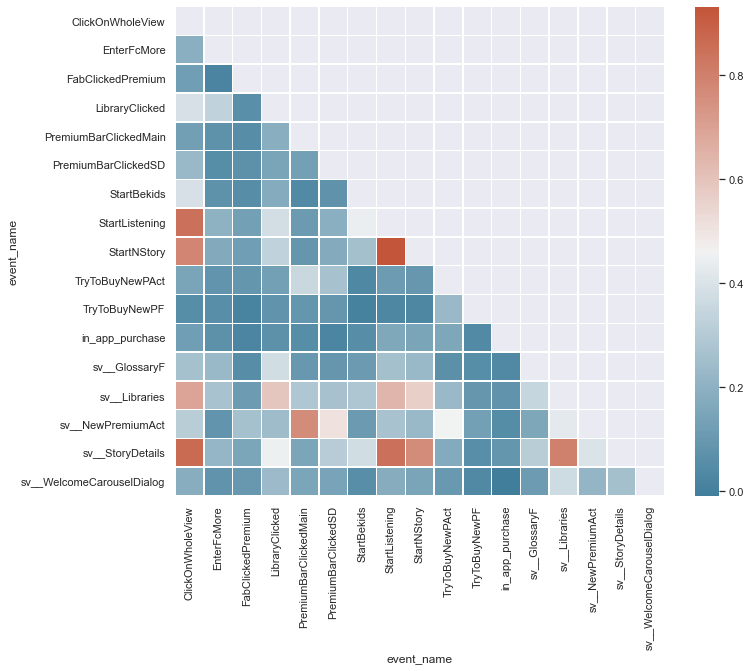

In [91]:
corr = df_log.corr()
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=bool)) # removing the other side of the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap,linewidths=.5,square=True)
plt.show()
#there is no really correlated events with in_app_purchase

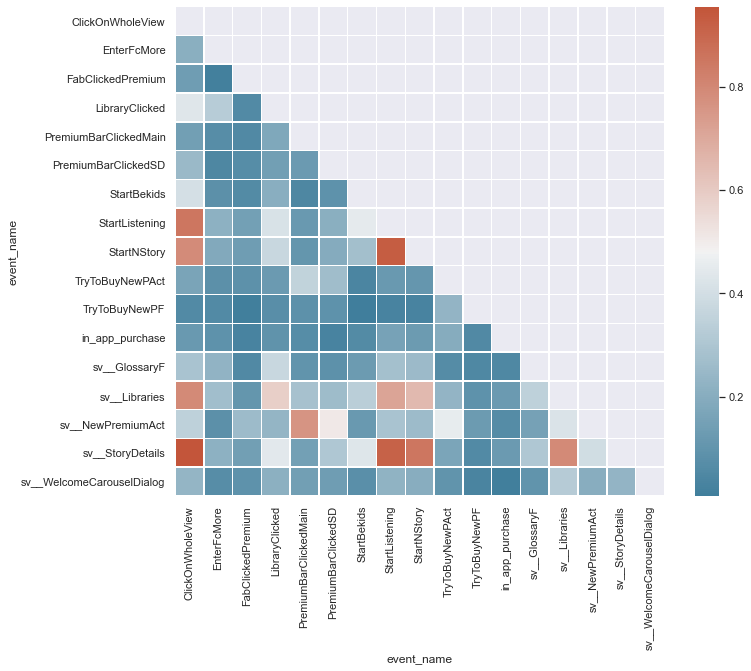

In [92]:
corr = df_log[df_log.platform=='Android'].corr()
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=bool)) # removing the other side of the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap,linewidths=.5,square=True)
plt.show()
#only android also does not show any correlation

**Logistic Regression with All Events**

In [66]:
cols = ['ClickOnWholeView', 'EnterFcMore','FabClickedPremium', 'LibraryClicked', 'PremiumBarClickedMain','PremiumBarClickedSD', 'StartBekids', 'StartListening', 'StartNStory','TryToBuyNewPAct', 'TryToBuyNewPF', 'sv__GlossaryF','sv__Libraries', 'sv__NewPremiumAct', 'sv__StoryDetails','sv__WelcomeCarouselDialog']

In [93]:
y = df_log['in_app_purchase']
X = df_log[cols]
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
model.summary()
#logistic regression for both platforms

         Current function value: 0.046688
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        in_app_purchase   No. Observations:               121454
Model:                          Logit   Df Residuals:                   121437
Method:                           MLE   Df Model:                           16
Date:                Fri, 11 Dec 2020   Pseudo R-squ.:                  0.1445
Time:                        21:40:29   Log-Likelihood:                -5670.4
converged:                      False   LL-Null:                       -6628.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -4.7558      0.043   -110.913      0.000      -4.840      -4.672
ClickOnWholeView             -0.0060      0.009     -0.694      0.488      -0.023       0.011
EnterFcMore                   0.2442      0.060      4.056      0.000       0.126       0.362
FabClickedPremium             0.8665      0.109      7.940      0.000       0.653       1.080
LibraryClicked                0.0535      0.014      3.701      0.000       0.025       0.082
PremiumBarClickedMain         0.2284      0.080      2.862      0.004       0.072       0.385
PremiumBarClickedSD           0.1678      0.107      1.572      0.116      -0.041       0.377
StartBekids                  -0.1741      0.031     -5.659      0.000      -0.234      -0.114
StartListening                0.3250      0.019     17.372      0.000       0.288       0.362
StartNStory                  -0.1107      0.016     -6.913      0.000      -0.142      -0.079
TryToBuyNewPAct               1.2480      0.081     15.481      0.000       1.090       1.406
TryToBuyNewPF                 0.0230      0.029      0.808      0.419      -0.033       0.079
sv__GlossaryF                 0.0756      0.051      1.485      0.138      -0.024       0.175
sv__Libraries                -0.0042      0.006     -0.733      0.464      -0.016       0.007
sv__NewPremiumAct            -0.5136      0.067     -7.647      0.000      -0.645      -0.382
sv__StoryDetails             -0.0664      0.007     -9.929      0.000      -0.079      -0.053
sv__WelcomeCarouselDialog    -0.5360      0.060     -8.915      0.000      -0.654      -0.418
=============================================================================================
"""

In [97]:
y = df_log[df_log.platform=='Android']['in_app_purchase']
X = df_log[df_log.platform=='Android'][cols]
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
model.summary()
#logistic regression only for Android

Optimization terminated successfully.
         Current function value: 0.035332
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        in_app_purchase   No. Observations:               106224
Model:                          Logit   Df Residuals:                   106207
Method:                           MLE   Df Model:                           16
Date:                Fri, 11 Dec 2020   Pseudo R-squ.:                  0.1654
Time:                        21:44:02   Log-Likelihood:                -3753.1
converged:                       True   LL-Null:                       -4496.9
Covariance Type:            nonrobust   LLR p-value:                2.371e-307
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.1331      0.053    -96.104      0.000      -5.238      -5.028
ClickOnWholeView              0.0727      0.018      4.031      0.000       0.037       0.108
EnterFcMore                   0.2881      0.061      4.705      0.000       0.168       0.408
FabClickedPremium             0.8176      0.110      7.412      0.000       0.601       1.034
LibraryClicked                0.0534      0.014      3.724      0.000       0.025       0.082
PremiumBarClickedMain         0.2004      0.081      2.484      0.013       0.042       0.358
PremiumBarClickedSD           0.1798      0.110      1.637      0.102      -0.035       0.395
StartBekids                  -0.0752      0.029     -2.551      0.011      -0.133      -0.017
StartListening                0.4048      0.025     16.251      0.000       0.356       0.454
StartNStory                  -0.1174      0.017     -6.871      0.000      -0.151      -0.084
TryToBuyNewPAct               1.2306      0.079     15.664      0.000       1.077       1.385
TryToBuyNewPF                 0.0276      0.028      0.976      0.329      -0.028       0.083
sv__GlossaryF                 0.1133      0.047      2.408      0.016       0.021       0.205
sv__Libraries                -0.0039      0.006     -0.606      0.544      -0.017       0.009
sv__NewPremiumAct            -0.4682      0.068     -6.930      0.000      -0.601      -0.336
sv__StoryDetails             -0.1431      0.015     -9.545      0.000      -0.173      -0.114
sv__WelcomeCarouselDialog    -0.3356      0.057     -5.852      0.000      -0.448      -0.223
=============================================================================================
"""

**Query with 30 days and +30 minutes**

In [98]:
query="""with initial_dataset as (
  select
    case 
      when event_name like 'sv__OnBoardingTutorialVi%' then 'sv__OnBoardingTutorialView'
      else event_name
    end as event_name,
    optional_label,
    event_timestamp,
    event_date,
    user_id,
    user_pseudo_id,
    ga_session_id,
    user_history_event_number,
    session_event_number,
    platform,
    device_language,
    country
  from
    analytics_151430920.firebase_facts_events as eve
  where
    eve.event_timestamp >= '2020-11-01'
  and
    eve.event_name in ('sv__OnBoardingTutorialVi','sv__WelcomeCarouselDialog','sv__NewPremiumAct','TryToBuyNewPAct','TryToBuyNewPF','ClickOnWholeView','StartListening','sv__StoryDetails','StartNStory','StartBekids','FabClickedPremium','PremiumBarClickedSD','PremiumBarClickedMain','sv__AAPageA','sv__ProPageA','sv_GoldPageA','sv__AAPageF','sv__ProPageF','sv__GoldPageF','EnterFcMore','sv__GlossaryF','LibraryClicked','sv__Libraries','PlayPrevParagraph','PlayNextParagraphFromBut','sv__OnBoardingTutorialVie',"in_app_purchase","PurchaseNormal")
),   
premium_promo_shown as (
  select distinct
    user_pseudo_id,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_premium_promo_shown_timestamp
  from
    initial_dataset
  where
    event_name = 'sv__WelcomeCarouselDialog'
),
purchases as (
  select distinct
    'in_app_purchase' as event_name,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_timestamp,
    first_value(event_date) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_date,
    first_value(optional_label) over (partition by user_pseudo_id order by event_timestamp) as optional_label,
    last_value(user_id) over (partition by user_pseudo_id order by event_timestamp) as user_id,
    user_pseudo_id,
    first_value(ga_session_id) over (partition by user_pseudo_id order by event_timestamp) as ga_session_id,
    first_value(user_history_event_number) over (partition by user_pseudo_id order by event_timestamp) as user_history_event_number,
    first_value(session_event_number) over (partition by user_pseudo_id order by event_timestamp) as session_event_number,
    first_value(platform) over (partition by user_pseudo_id order by event_timestamp) as platform,
    first_value(device_language) over (partition by user_pseudo_id order by event_timestamp) as device_language,
    first_value(country) over (partition by user_pseudo_id order by event_timestamp) as country
  from
    initial_dataset
  where
    event_name in ('in_app_purchase','PurchaseNormal')
),
relevant_purchases as (
  select
    pu.event_name,
    pu.first_purchase_timestamp,
    pu.first_purchase_date,
    ps.first_premium_promo_shown_timestamp,
    pu.optional_label,
    pu.user_id,
    pu.user_pseudo_id,
    pu.ga_session_id,
    pu.user_history_event_number,
    pu.session_event_number,
    pu.platform,
    pu.device_language,
    pu.country
  from
    purchases as pu
  join
    premium_promo_shown as ps on ps.user_pseudo_id = pu.user_pseudo_id
  where
    pu.first_purchase_timestamp > timestamp_add(ps.first_premium_promo_shown_timestamp, interval 30 minute)
),
relevant_events as (
  select
    ini.event_name,
    ini.event_timestamp,
    ini.event_date,
    ini.optional_label,
    ini.user_id,
    ini.user_pseudo_id,
    ini.ga_session_id,
    ini.user_history_event_number,
    ini.session_event_number,
    ini.platform,
    ini.device_language,
    ini.country
  from
    initial_dataset as ini
  left join
    premium_promo_shown as ps on ps.user_pseudo_id = ini.user_pseudo_id
  where
    event_name != 'in_app_purchase'
  and
    ini.event_timestamp between ps.first_premium_promo_shown_timestamp and timestamp_add(first_premium_promo_shown_timestamp, interval 30 day)
  union all
  select
    rep.event_name,
    rep.first_purchase_timestamp as event_timestamp,
    rep.first_purchase_date as event_date,
    rep.optional_label,
    rep.user_id,
    rep.user_pseudo_id,
    rep.ga_session_id,
    rep.user_history_event_number,
    rep.session_event_number,
    rep.platform,
    rep.device_language,
    rep.country
  from
    relevant_purchases as rep
  where
    rep.first_purchase_timestamp between rep.first_premium_promo_shown_timestamp and timestamp_add(rep.first_premium_promo_shown_timestamp, interval 30 day)
)
select
  user_pseudo_id,
  event_name,
  count(event_timestamp) as occurrences_count,
  min(event_timestamp) as first_event_timestamp,
  max(event_timestamp) as last_event_timestamp
from
  relevant_events
group by 1,2;"""
df2 = pandas_gbq.read_gbq(query, project_id= 'beelinguapp')

**Investigating Dataframe and Creating Pivot**

In [100]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408117 entries, 0 to 408116
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   user_pseudo_id         408117 non-null  object             
 1   event_name             408117 non-null  object             
 2   occurrences_count      408117 non-null  int64              
 3   first_event_timestamp  408117 non-null  datetime64[ns, UTC]
 4   last_event_timestamp   408117 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(1), object(2)
memory usage: 12.5+ MB


In [101]:
df2["event_name"].value_counts() #why do we have still sv_WelcomeCarouselDialog here? although there is less purchase

sv__WelcomeCarouselDialog     64464
sv__Libraries                 60524
sv__StoryDetails              49357
ClickOnWholeView              48778
StartListening                43228
StartNStory                   37712
LibraryClicked                21321
sv__NewPremiumAct             17051
sv__AAPageA                    9859
PremiumBarClickedMain          9642
sv__ProPageA                   7294
sv__AAPageF                    6479
sv__ProPageF                   5025
sv__GlossaryF                  4911
StartBekids                    4364
PremiumBarClickedSD            4341
PlayNextParagraphFromBut       4120
FabClickedPremium              2437
TryToBuyNewPAct                2085
sv__GoldPageF                  2044
EnterFcMore                    1798
TryToBuyNewPF                   741
sv__OnBoardingTutorialView      273
PlayPrevParagraph               173
in_app_purchase                  96
Name: event_name, dtype: int64

In [102]:
df_log2 = df2.pivot_table(index=["user_pseudo_id"],columns=["event_name"],fill_value=0)

In [103]:
df_log2.columns = df_log2.columns.droplevel() #to get rid of the first column name of nested column

In [104]:
df_log2.reset_index(inplace=True)

**Logistic Regressions for +30 mins**

In [105]:
cols2 = ['ClickOnWholeView',
 'EnterFcMore',
 'FabClickedPremium',
 'LibraryClicked',
 'PlayNextParagraphFromBut',
 'PlayPrevParagraph',
 'PremiumBarClickedMain',
 'PremiumBarClickedSD',
 'StartBekids',
 'StartListening',
 'StartNStory',
 'TryToBuyNewPAct',
 'TryToBuyNewPF',
 'sv__AAPageA',
 'sv__AAPageF',
 'sv__GlossaryF',
 'sv__GoldPageF',
 'sv__Libraries',
 'sv__NewPremiumAct',
 'sv__OnBoardingTutorialView',
 'sv__ProPageA',
 'sv__ProPageF',
 'sv__StoryDetails',
 'sv__WelcomeCarouselDialog']

In [106]:
y = df_log2['in_app_purchase']
X = df_log2[cols2]
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.007341
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        in_app_purchase   No. Observations:                64464
Model:                          Logit   Df Residuals:                    64439
Method:                           MLE   Df Model:                           24
Date:                Fri, 11 Dec 2020   Pseudo R-squ.:                  0.3435
Time:                        21:52:10   Log-Likelihood:                -473.23
converged:                       True   LL-Null:                       -720.84
Covariance Type:            nonrobust   LLR p-value:                 1.632e-89
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -7.4580      0.334    -22.322      0.000      -8.113      -6.803
ClickOnWholeView              -0.0918      0.025     -3.658      0.000      -0.141      -0.043
EnterFcMore                    0.2950      0.165      1.783      0.075      -0.029       0.619
FabClickedPremium              0.7055      0.259      2.728      0.006       0.199       1.212
LibraryClicked                 0.1011      0.021      4.716      0.000       0.059       0.143
PlayNextParagraphFromBut       0.0222      0.006      3.649      0.000       0.010       0.034
PlayPrevParagraph             -0.0250      0.359     -0.070      0.945      -0.729       0.679
PremiumBarClickedMain          0.4250      0.117      3.633      0.000       0.196       0.654
PremiumBarClickedSD            0.8053      0.178      4.526      0.000       0.457       1.154
StartBekids                   -0.1243      0.052     -2.393      0.017      -0.226      -0.022
StartListening                 0.1140      0.040      2.857      0.004       0.036       0.192
StartNStory                   -0.0596      0.026     -2.282      0.022      -0.111      -0.008
TryToBuyNewPAct                0.5205      0.092      5.676      0.000       0.341       0.700
TryToBuyNewPF                  0.0698      0.032      2.197      0.028       0.008       0.132
sv__AAPageA                    0.0831      0.086      0.961      0.336      -0.086       0.252
sv__AAPageF                    0.1595      0.195      0.817      0.414      -0.223       0.542
sv__GlossaryF                 -0.3354      0.090     -3.730      0.000      -0.512      -0.159
sv__GoldPageF                 -0.0520      0.240     -0.216      0.829      -0.523       0.419
sv__Libraries                  0.0043      0.002      2.476      0.013       0.001       0.008
sv__NewPremiumAct             -0.5288      0.114     -4.655      0.000      -0.751      -0.306
sv__OnBoardingTutorialView    -0.0992      0.238     -0.416      0.677      -0.566       0.368
sv__ProPageA                   0.0417      0.107      0.389      0.698      -0.168       0.252
sv__ProPageF                   0.1618      0.134      1.208      0.227      -0.101       0.424
sv__StoryDetails               0.0432      0.020      2.167      0.030       0.004       0.082
sv__WelcomeCarouselDialog     -0.0554      0.284     -0.195      0.845      -0.612       0.501
==============================================================================================
"""

In [107]:
cols3 = [ 'ClickOnWholeView',
 'EnterFcMore',
 'LibraryClicked',
 'PlayNextParagraphFromBut',
 'PlayPrevParagraph',
 'StartBekids',
 'StartListening',
 'StartNStory',
 'sv__GlossaryF',
 'sv__Libraries',
 'sv__NewPremiumAct',
 'sv__OnBoardingTutorialView',
 'sv__StoryDetails',
]

In [108]:
y = df_log2['in_app_purchase']
X = df_log2[cols3]
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.008373
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        in_app_purchase   No. Observations:                64464
Model:                          Logit   Df Residuals:                    64450
Method:                           MLE   Df Model:                           13
Date:                Fri, 11 Dec 2020   Pseudo R-squ.:                  0.2512
Time:                        21:53:48   Log-Likelihood:                -539.78
converged:                       True   LL-Null:                       -720.84
Covariance Type:            nonrobust   LLR p-value:                 2.172e-69
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -7.2158      0.138    -52.396      0.000      -7.486      -6.946
ClickOnWholeView              -0.0935      0.023     -4.088      0.000      -0.138      -0.049
EnterFcMore                    0.3843      0.195      1.971      0.049       0.002       0.767
LibraryClicked                 0.1502      0.026      5.719      0.000       0.099       0.202
PlayNextParagraphFromBut       0.0277      0.006      4.826      0.000       0.016       0.039
PlayPrevParagraph             -0.0101      0.327     -0.031      0.975      -0.651       0.631
StartBekids                   -0.1364      0.043     -3.200      0.001      -0.220      -0.053
StartListening                 0.1241      0.029      4.291      0.000       0.067       0.181
StartNStory                   -0.0733      0.021     -3.434      0.001      -0.115      -0.031
sv__GlossaryF                 -0.3767      0.097     -3.888      0.000      -0.567      -0.187
sv__Libraries                  0.0048      0.002      3.067      0.002       0.002       0.008
sv__NewPremiumAct              0.0260      0.009      2.907      0.004       0.008       0.044
sv__OnBoardingTutorialView    -0.0893      0.205     -0.435      0.664      -0.492       0.313
sv__StoryDetails               0.0413      0.015      2.673      0.008       0.011       0.072
==============================================================================================
"""

In [110]:
df2.to_csv('30days30minutes.csv')

In [111]:
df.to_csv('allevents.csv')